In [52]:
import csv
import pandas as pd
from load_clean_review import load_and_clean_reviews

PATH = "data/Digital_Software.tsv"

df = load_and_clean_reviews(PATH)

In [53]:
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,False,True,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,False,True,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,False,True,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,False,True,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,False,True,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102079,US,41754720,R19OFJV91M7D8X,B000YMR61A,141393130,TurboTax Deluxe Federal + State 2007,Digital_Software,2,12,13,False,False,"Easy to use, 1 comment 1 serious problem",I chose the deluxe version CD because of mortg...,2008-02-11
102080,US,51669529,R1I6G894K5AGG5,B000YMR61A,141393130,TurboTax Deluxe Federal + State 2007,Digital_Software,4,6,9,False,False,Schedule C IS for business- figures it would ...,"Schedule C IS for business, so figures it wou...",2008-02-08
102081,US,24731012,R17OE43FFEP81I,B000YMR5X4,234295632,TurboTax Premier Federal + State 2007,Digital_Software,2,9,16,False,False,Hassel to download,I wish that companies can test several scenari...,2008-02-05
102082,US,16049580,R15MGDDK63B52Z,B000YMR61A,141393130,TurboTax Deluxe Federal + State 2007,Digital_Software,3,14,14,False,False,beware of vista,i just installed turbotax deluxe 2007. If you ...,2008-02-05


In [14]:
min_date = df["review_date"].min()
max_date = df["review_date"].max()

print("Earliest review:", min_date)
print("Latest review:", max_date)



# Extract year and month as separate columns
df["year"] = df["review_date"].dt.year
df["month"] = df["review_date"].dt.month

# Group by year and collect unique months
months_per_year = df.groupby("year")["month"].unique()

print(months_per_year)

print(months_per_year.loc[2012.0])

Earliest review: 2008-01-26 00:00:00
Latest review: 2015-08-31 00:00:00
year
2008.0                      [12.0, 9.0, 4.0, 3.0, 2.0, 1.0]
2009.0    [12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4....
2010.0    [12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4....
2011.0    [12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4....
2012.0    [12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4....
2013.0    [12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4....
2014.0    [12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4....
2015.0             [8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0]
Name: month, dtype: object
[12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.]


In [15]:

df_2012 = df[df["review_date"].dt.year == 2012].copy()

df_2012


df_2012["review_length"] = df_2012["review_body"].fillna("").str.split().str.len()
df_2012 = df_2012[df_2012["review_length"] > 0]

df_2012["length_bin"] = pd.qcut(
    df_2012["review_length"], q=3, labels=["short", "medium", "long"], duplicates="drop"
)

df_2012

target_n = 4000
labels = ["short", "medium", "long"]

per = target_n // len(labels)   # base quota per bucket (≈ 1333)
rem = target_n - per * len(labels)   # leftover rows to distribute


parts = []
for i, label in enumerate(labels):
    want = per + (1 if i < rem else 0)  # bucket-specific quota
    have = (df_2012["length_bin"] == label).sum()  # how many rows exist in that bucket
    take = min(want, have)  # don’t over-ask if bucket is too small
    if take > 0:
        parts.append(
            df_2012[df_2012["length_bin"] == label].sample(n=take, random_state=42)
        )

sampled_df = pd.concat(parts)

sampled_df

shuffled_df = (
    sampled_df
      .sample(frac=1, random_state=42)  
      .reset_index(drop=True)          
)

shuffled_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,month,review_length,length_bin
0,US,43890952,R11VQHZKNZLZMS,B007USG5JK,420461569,Adobe CS6 Design Standard Student and Teacher ...,Digital_Software,1,4,9,False,True,DO not BUY THIS SOFTWARE,"As stated above with the other reviewer, you c...",2012-09-05,2012.0,9.0,36,short
1,US,12636586,R17A4EE8P53E0V,B005S4Y13K,70285996,TurboTax Deluxe Federal + E-file + State 2011 ...,Digital_Software,3,0,0,False,True,a few annoying things,I have been using Turbo tax for about 4 years ...,2012-01-29,2012.0,1.0,176,long
2,US,28822780,R1401XI3KSVU4,B004E9SKEG,858579694,Microsoft Windows 7 Anytime Upgrade [Home Prem...,Digital_Software,5,0,0,False,True,smooth upgrade,This upgrade was very easy to follow and the p...,2012-03-21,2012.0,3.0,28,short
3,US,42076909,R1SOP6G5Y8B483,B005S4YGYO,940910541,TurboTax Premier Federal + E-file + State 2011...,Digital_Software,2,1,1,False,True,Mac Download - Transfer from H&R Block 2010 no...,I just spent half-an-hour on the phone with th...,2012-02-28,2012.0,2.0,107,long
4,US,14913586,RXC8U82LDCE2X,B009KTSKVI,369346636,Home Designer Suite 2014,Digital_Software,1,22,31,False,False,Not recommended.,This software is ok. It has severe limitations...,2012-11-28,2012.0,11.0,156,long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,US,12171401,R1GJ0XENVJZR8G,B0068TJ7OC,740565112,H&R Block At Home 2011 Deluxe + State,Digital_Software,5,1,1,False,True,Great Tax Program,Tax self preparation has never been so easy. E...,2012-03-04,2012.0,3.0,37,short
3996,US,18419998,RD3TO3BRU0713,B005O24CWG,590526601,Microsoft Office Home & Business 2010 Key Card...,Digital_Software,5,0,0,False,True,Quick and Easy,Downloaded and installed on a customers comput...,2012-10-26,2012.0,10.0,22,short
3997,US,10288362,R2DPSWIPK5QCJO,B005HYI8R6,680721066,Quicken Deluxe 2012,Digital_Software,3,0,0,False,True,"Quicken Deluxe, 2012",This version of Quicken Deluxe is quite differ...,2012-03-15,2012.0,3.0,22,short
3998,US,27221688,R1JD15VDKQTDBF,B008S0IMCC,534964191,Quicken Deluxe 2013,Digital_Software,1,8,9,False,False,Don't buy this POS,I have used various version of Microsoft Money...,2012-11-29,2012.0,11.0,134,long


In [16]:
# Recreate qcut but keep the Interval objects
bins = pd.qcut(df_2012["review_length"], q=3, duplicates="drop")

# Look at unique intervals
print(bins.cat.categories)

IntervalIndex([(0.999, 40.0], (40.0, 94.0], (94.0, 2621.0]], dtype='interval[float64, right]')


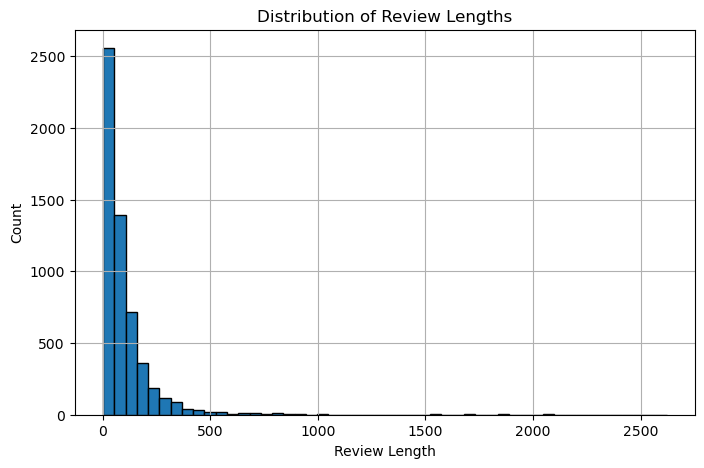

In [57]:
import matplotlib.pyplot as plt
from month_bin_shuffle import add_length_info, stratified_sample_by_month_and_bin
df_2012 = df[df["review_date"].dt.year == 2012].copy()
df_2012 = add_length_info(df_2012)
plt.figure(figsize=(8,5))
df_2012["review_length"].hist(bins=50, edgecolor="black")
plt.xlabel("Review Length")
plt.ylabel("Count")
plt.title("Distribution of Review Lengths")
plt.show()

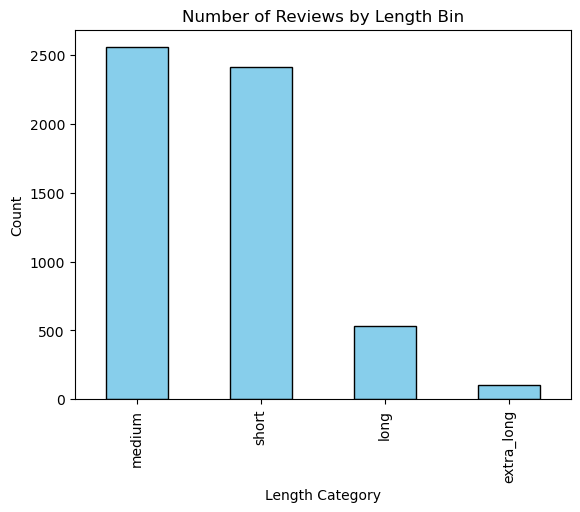

In [58]:

from month_bin_shuffle import add_length_info, stratified_sample_by_month_and_bin
df_2012 = df[df["review_date"].dt.year == 2012].copy()
df_2012 = add_length_info(df_2012)
df_2012["length_bin"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Length Category")
plt.ylabel("Count")
plt.title("Number of Reviews by Length Bin")
plt.show()

## Balanced on both month ad review length

In [54]:
from month_bin_shuffle import add_length_info, stratified_sample_by_month_and_bin

df_2012 = df[df["review_date"].dt.year == 2012].copy()

df_2012 = add_length_info(df_2012)
df_2012 = stratified_sample_by_month_and_bin(df_2012, target_n=4000)

df_2012


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_length,length_bin,month
0,US,30306005,R3QZBXMFWU3U7T,B003PDMNCC,978035146,Quicken Essentials for Mac,Digital_Software,4,0,0,False,True,Basic and that's fine by me.,This is a very basic addition of Quicken. If w...,2012-02-02,53,medium,2012-02
1,US,20662494,R237U0NF29209C,B0068TJ7OC,740565112,H&R Block At Home 2011 Deluxe + State,Digital_Software,5,0,0,False,True,"Great product, great price",I can't imagine every going to the store to bu...,2012-12-18,36,short,2012-12
2,US,50983035,R124MRWZXSEY2C,B004E9SKEG,858579694,Microsoft Windows 7 Anytime Upgrade [Home Prem...,Digital_Software,5,2,2,False,True,Outstanding! Easy to Upgrade,"Nice to be able to get the key electronically,...",2012-02-16,62,medium,2012-02
3,US,39885773,R3OVT62L71CSOJ,B008S0IP38,383426331,Quicken Premier 2013,Digital_Software,2,6,6,False,True,"Disappointed, again.",Yet another iteration of Quicken has come with...,2012-12-29,204,long,2012-12
4,US,15355636,R2ZW39MDFXMLSW,B008S0IE5M,835509971,Quicken Home & Business 2013,Digital_Software,1,6,6,False,False,Slow like molasses in January,Over the last 10 years Quicken became bloated....,2012-10-11,268,long,2012-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,US,50185801,R1Q0CW6MA8881D,B005S4YBVM,92728872,TurboTax Home & Business Federal + E-file + St...,Digital_Software,1,2,2,False,True,Downloads as the 2010 version,Amazon has seriously messed up here. I have no...,2012-04-13,43,short,2012-04
3996,US,17802801,R1BP8O3BZSDOI8,B005S4Y13K,70285996,TurboTax Deluxe Federal + E-file + State 2011 ...,Digital_Software,1,2,2,False,True,I am NOT happy!,"Downloaded this file, but have been unable to ...",2012-04-14,61,medium,2012-04
3997,US,15852039,R31BV1FRUCB05O,B005S4Y13K,70285996,TurboTax Deluxe Federal + E-file + State 2011 ...,Digital_Software,5,0,0,False,True,"Solid product, easy to use",Have used Turbo Tax for years without any prob...,2012-03-03,27,short,2012-03
3998,US,12584236,R125IL3FFVB0NG,B009G6SEKM,440579914,Adobe Photoshop Elements 11,Digital_Software,5,1,1,False,True,Easy download - Good software,I would buy software from Amazon again. PSE i...,2012-12-26,23,short,2012-12


In [55]:
LENGTH_BINS = [0, 50, 200, 500, float("inf")]
LENGTH_LABELS = ["short", "medium", "long", "extra_long"]
# --- Check bin ranges ---
for label, (low, high) in zip(LENGTH_LABELS, zip(LENGTH_BINS[:-1], LENGTH_BINS[1:])):
    upper = int(high) if high != float("inf") else "∞"
    print(f"{label:>10}: {low+1} – {upper} words")

# --- Count per (month × length_bin) ---
counts = df_2012.groupby(["month", "length_bin"]).size().unstack(fill_value=0)

print("\nCounts per (month × length_bin):")
print(counts)

# optional: quick totals per bin
print("\nTotals per bin:")
print(counts.sum(axis=0))

# optional: quick totals per month
print("\nTotals per month:")
print(counts.sum(axis=1))

     short: 1 – 50 words
    medium: 51 – 200 words
      long: 201 – 500 words
extra_long: 501 – ∞ words

Counts per (month × length_bin):
length_bin  short  medium  long  extra_long
month                                      
2012-01       121     161    57           8
2012-02       136     174    66           8
2012-03       145     166    43           7
2012-04       127     160    64          13
2012-05       110     118    30           9
2012-06        95     100    26           3
2012-07        88      99    24           2
2012-08       107     104    24           6
2012-09       119     117    27           3
2012-10       122     154    60          19
2012-11       166     144    45          11
2012-12       315     218    66          13

Totals per bin:
length_bin
short         1651
medium        1715
long           532
extra_long     102
dtype: int64

Totals per month:
month
2012-01    347
2012-02    384
2012-03    361
2012-04    364
2012-05    267
2012-06    224
2012-07    2

/var/folders/zm/pz0q6_fn2zv0lr2bzbh6_8mc0000gn/T/ipykernel_22604/1777719214.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_2012.groupby(["month", "length_bin"]).size().unstack(fill_value=0)


In [56]:
df_2012.to_csv("software_2012.csv", index=False)